# Creating dataset

# Creating classification model

In [1]:
import os
import pickle
import numpy as np
import os
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import metrics
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import keras
import shutil
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

Using TensorFlow backend.


In [2]:
DATASET_PATH = '../../datasets/Classification/Dataset - 3 dias/'
DATASET_PATH2 = '../../datasets/Classification/Dataset - 7 dias/'
CATEGORIES = ["Normal", "Anormal", "Morta"]

##### Read dataset

In [3]:
IMG_SIZE = 256
NUM_CLASSES = 3
def read_dataset():
    images_raw = open(os.path.join(DATASET_PATH, "images.pickle" ), "rb")
    images = pickle.load(images_raw)

    labels_raw = open(os.path.join(DATASET_PATH, "labels.pickle" ), "rb")
    labels = pickle.load(labels_raw)

    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels

def read_dead_plants():
    images_raw = open(os.path.join(DATASET_PATH2, "images.pickle" ), "rb")
    images = pickle.load(images_raw)

    labels_raw = open(os.path.join(DATASET_PATH2, "labels.pickle" ), "rb")
    labels = pickle.load(labels_raw)

    images = np.array(images)
    labels = np.array(labels)
    
    images = images[labels==2]
    labels = labels[labels==2]
    
    return images, labels

###### Turn it into a binary classification problem

In [4]:
def to_binary(labels):
    labels[labels == 2] = 1
    return labels
    

###### Train Test split

In [5]:
def count_samples(train_labels, test_labels):
    print("In training:")
    for i in range(0,NUM_CLASSES):
        print(f'Class {i}: {round(100 * np.count_nonzero(np.array(train_labels) == i) / len(train_labels), 2)}%')
    print("In test:")
    for i in range(0,NUM_CLASSES):
        print(f'Class {i}: {round(100 * np.count_nonzero(np.array(test_labels) == i) / len(test_labels), 2)}%')


def train_test_split(images, labels):

    from sklearn.model_selection import train_test_split

    train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.1, stratify=labels)
    
    print("In training:")
    for i in range(0,len(np.unique(labels))):
        print(f'Class {i}: {round(100 * np.count_nonzero(np.array(train_labels) == i) / len(train_labels), 2)}%')
    print("In test:")
    for i in range(0,len(np.unique(labels))):
        print(f'Class {i}: {round(100 * np.count_nonzero(np.array(test_labels) == i) / len(test_labels), 2)}%')
        
    return train_images, test_images, train_labels, test_labels

#### Ajustando o dataset desbalanceado

###### Data augmentation -> data generator

In [6]:
# data augmentation with ImageDataGenerator -> did not go well
# from keras.preprocessing.image import ImageDataGenerator
# datagen = ImageDataGenerator(
#     featurewise_center=True,
#     featurewise_std_normalization=False,
#     rotation_range=20,
#     width_shift_range=0.2,
#     height_shift_range=0.2,
#     horizontal_flip=True,
#     validation_split=0.25
# )
# datagen.fit(train_images)

# # it = datagen.flow(train_images, batch_size=1, save_to_dir="test", shuffle= True)

# # # generate samples and plot
# # for i in range(50):
# #      # generate batch of images
# #     batch = it.next()
# #     # convert to unsigned integers for viewing
# #     image = batch[0].astype('uint8')
# #     # plot raw pixel data
# #     plt.imshow(image, cmap="gray")
# #     plt.show()
# # show the figure

###### Weighted Classes 

In [7]:
# Trying class weights
# it does not work with one hot encoded data
# from sklearn.utils import class_weight
# class_weights = class_weight.compute_class_weight('balanced',
#                                                  np.unique(train_labels),
#                                                  train_labels)

def get_sample_weights(train_labels):
    from sklearn.utils import compute_sample_weight
    
    return compute_sample_weight('balanced', train_labels)  #->>>> remember to add the weights in model.fit

###### SMOTE

In [8]:
# classes, counts = np.unique(train_labels, return_counts=True)
# print(f"The number of elements for each class in training now are\nClass 0: {counts[0]}\nClass 1 {counts[1]}\nClass 2 {counts[2]}\n")

In [9]:
# from imblearn.over_sampling import SMOTE
# sm = SMOTE(random_state=42)

# train_images_shape = train_images.shape
# train_images = train_images.reshape((train_images_shape[0], IMG_SIZE * IMG_SIZE * 3))
# train_images, train_labels = sm.fit_resample(train_images, train_labels)


In [10]:
# train_images_shape = train_images.shape
# train_images = train_images.reshape((train_images_shape[0], IMG_SIZE, IMG_SIZE, 3))


In [11]:
# classes, counts = np.unique(train_labels, return_counts=True)
# print(f"The number of elements for each class in training now are\nClass 0: {counts[0]}\nClass 1 {counts[1]}\nClass 2 {counts[2]}\n")

##### One hot label encoding

In [12]:
def to_one_hot(data):
    import pandas as pd
    data = pd.get_dummies(data)
    data = pd.DataFrame.to_numpy(data)
    return data

##### Normalizing training images

In [13]:
def normalize_images(data):
    data = tf.keras.utils.normalize(data, axis=0, order=2)
    return data

### Creating the model


In [14]:
EPOCHS = None
TRAIN_TEST_SPLIT = None
BATCH_SIZE = None
# print((1 - TRAIN_TEST_SPLIT) * train_images.shape[0],BATCH_SIZE)

METRICDIR = '../metricas/classificacao/7_d/tests-binary'

MODELDIR = os.path.join(METRICDIR, "adhoc")

CHECKPOINT_DIR = os.path.join(MODELDIR, "models") 

if os.path.exists(MODELDIR):
    shutil.rmtree(MODELDIR)
    os.makedirs(CHECKPOINT_DIR)
    
my_metrics = ["accuracy",
       tf.keras.metrics.Precision(),
       tf.keras.metrics.Recall(),
       tf.keras.metrics.AUC(),
       tf.keras.metrics.TruePositives(),
       tf.keras.metrics.TrueNegatives(),
       tf.keras.metrics.FalsePositives(),
       tf.keras.metrics.FalseNegatives(),]

In [22]:
def create_model():
       
    model = Sequential()

    model.add(   Conv2D(8, (3,3), input_shape=(IMG_SIZE,IMG_SIZE, 3))  )
    model.add(Dropout(rate=0.3))
    model.add(Activation("relu"))

    model.add(Conv2D(6, (3,3)))
    model.add(Dropout(rate=0.3))
    model.add(Activation("relu"))
    
    model.add(Conv2D(2, (3,3)))
    model.add(Dropout(rate=0.4))
    model.add(Activation("relu"))
    
    model.add(Flatten())
    model.add(Dense(3))
    
    model.add(Activation("softmax"))
    
    opt = tf.keras.optimizers.Adam()
    model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=my_metrics)
    
    return model

def get_model_name(k):
    return 'model_'+str(k)

def plot_metric(history,metric_name, chart_name, save_dir, save = False, show = False):
    plt.cla() 
    plt.plot(history.history[metric_name], label = metric_name + ' (training data)')
    plt.plot(history.history['val_' + metric_name], label = metric_name + ' (validation data)')
    plt.title(chart_name)
    plt.ylabel( metric_name + ' value')
    plt.xlabel('No. epoch')
    plt.legend(loc="upper left")
    if save:
        plt.savefig(os.path.join(save_dir, metric_name))
    if show:
        plt.show()
        
def plot_cm(cf_matrix, save_dir, save):
    
    import seaborn as sns; sns.set_theme()
   
    group_names = ['True Pos','False Pos','False Neg','True Neg']
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    plt.cla() 
    
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    if save:
        plt.savefig(os.path.join(save_dir, "confusion matrix"))
    plt.show()

##### Testing the model

In [23]:
def one_hot_to_1d(test_labels):
    
    test_labels_1d = []
    
    for label in test_labels:
        print()
        if (label == [1, 0]).all():
            test_labels_1d.append(0)
        elif (label == [0, 1]).all():
            test_labels_1d.append(1)
        else:
            test_labels_1d.append(2)
    
    return test_labels_1d
    
def get_predictions(model,test_images, test_labels):
    prediction = model.predict(test_images, batch_size=1)

    return tf.argmax(prediction, axis=-1)

In [24]:
def train_models(train_images, train_labels, num_folds=10):
    
    from sklearn.model_selection import StratifiedKFold
    
    kfold = StratifiedKFold(n_splits=num_folds)

    #metrics containers
    acc = []
    prec = []
    rec = []
    auc = []

    # K-fold Cross Validation model evaluation
    fold_no = 1
    for train, test in kfold.split(train_images, train_labels):

        count_samples(train_labels[train], train_labels[test])
        
#         from tf.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

        if fold_no - 1 == 0:
            idx_str = ""
        else:
            idx_str = f"_{fold_no}"
            
        fold_checkpoint_dir = os.path.join(CHECKPOINT_DIR, get_model_name(fold_no))
        
        if not os.path.exists(fold_checkpoint_dir):
            os.makedirs(fold_checkpoint_dir)
        
#         my_callbacks = [
# #             ModelCheckpoint(os.path.join(fold_checkpoint_dir,"model.h5"), monitor=f"val_precision", verbose=1, save_best_only=True, mode='max', save_freq='epoch'),
#             ReduceLROnPlateau(monitor=f'loss', factor=0.7, patience=2, min_lr=0.00000000001, mode='min'),
#         ]

        model = create_model()

        # Generate a print
        print('------------------------------------------------------------------------', end="\n\n")
        print(f'Training for fold {fold_no} ...')

#         # Fit data to model
#         history = model.fit(
#             train_images[train],
#             train_labels[train],
#             batch_size = BATCH_SIZE,
#             epochs = EPOCHS,
#             validation_split=TRAIN_TEST_SPLIT,
#             sample_weight=get_sample_weights(train_labels[train]),
#             callbacks=[my_callbacks])
        # Fit data to model
        history = model.fit(
            train_images[train],
            to_one_hot(train_labels[train]),
            batch_size = BATCH_SIZE,
            epochs = EPOCHS,
            validation_split=TRAIN_TEST_SPLIT,
            sample_weight=get_sample_weights(train_labels[train]))
        
        thresh = 0.5
        
        prediction = model.predict(train_images[test], batch_size=1)
        prediction = np.argmax(prediction, axis=1)
        
        #visualizing training
        NUM_METRICS = len(my_metrics) + 1
        for metric in list(history.history.keys())[:NUM_METRICS]:
            plot_metric(history, metric, metric + " for soybean classification", save_dir=fold_checkpoint_dir, save=True)
        
        print(metrics.confusion_matrix(train_labels[test], prediction))
            
        # Generate generalization metrics
        scores = model.evaluate(train_images[test], to_one_hot(train_labels[test]), verbose=0)
        print(f'Scores for fold {fold_no}:')
        for i in range(len(my_metrics)):   
            print(f'{model.metrics_names[i]} of {scores[i]}')

        acc.append(scores[1])
        prec.append(scores[2])
        rec.append(scores[3])
        auc.append(scores[4])

        # Increase fold number
        fold_no = fold_no + 1
        
    return acc, prec, rec, auc

##### Training

In [25]:
np.set_printoptions(threshold=np. inf)

images, labels = read_dataset()

dead_images, dead_labels = read_dead_plants()

images = np.concatenate((images, dead_images))
labels = np.concatenate((labels, dead_labels))

data = [x for x in zip(images,labels)]

import random

random.shuffle(data)

images = []
labels = []

for image, label in data:
    images.append(image)
    labels.append(label)
    
images = np.array(images)
labels = np.array(labels)

images = normalize_images(images)

In training:
Class 0: 73.69%
Class 1: 18.86%
Class 2: 7.45%
In test:
Class 0: 73.91%
Class 1: 19.13%
Class 2: 6.96%
------------------------------------------------------------------------

Training for fold 1 ...
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 775 samples, validate on 259 samples
Epoch 1/10
775/775 [==============================] - 8s 11ms/sample - loss: 0.8805 - accuracy: 0.5858 - precision: 0.7307 - recall: 0.3781 - auc: 0.7728 - true_positives: 293.0000 - true_negatives: 1442.0000 - false_positives: 108.0000 - false_negatives: 482.0000 - val_loss: 0.8253 - val_accuracy: 0.8069 - val_precision: 0.8383 - val_recall: 0.7606 - val_auc: 0.9404 - val_true_positives: 197.0000 - val_true_negatives: 480.0000 - val_false_positives: 38.0000 - val_false_negatives: 62.0000
Epoch 2/10
775/775 [==============================] - 2s 3ms/sample - loss: 0.6065 - accuracy: 0.8387 - precision: 0.8684 - recall: 0.8090 - auc: 0.9631 - true_positives: 627.0000 - true_negatives

775/775 [==============================] - 2s 3ms/sample - loss: 0.8557 - accuracy: 0.6594 - precision: 0.7196 - recall: 0.4271 - auc: 0.7969 - true_positives: 331.0000 - true_negatives: 1421.0000 - false_positives: 129.0000 - false_negatives: 444.0000 - val_loss: 1.1409 - val_accuracy: 0.7452 - val_precision: 0.5000 - val_recall: 0.0039 - val_auc: 0.8288 - val_true_positives: 1.0000 - val_true_negatives: 517.0000 - val_false_positives: 1.0000 - val_false_negatives: 258.0000
Epoch 6/10
775/775 [==============================] - 2s 3ms/sample - loss: 0.6690 - accuracy: 0.7535 - precision: 0.8000 - recall: 0.7019 - auc: 0.8859 - true_positives: 544.0000 - true_negatives: 1414.0000 - false_positives: 136.0000 - false_negatives: 231.0000 - val_loss: 0.9960 - val_accuracy: 0.6255 - val_precision: 0.6336 - val_recall: 0.3205 - val_auc: 0.7195 - val_true_positives: 83.0000 - val_true_negatives: 470.0000 - val_false_positives: 48.0000 - val_false_negatives: 176.0000
Epoch 7/10
775/775 [=======

775/775 [==============================] - 2s 3ms/sample - loss: 0.5576 - accuracy: 0.8400 - precision: 0.8604 - recall: 0.8194 - auc: 0.9544 - true_positives: 635.0000 - true_negatives: 1447.0000 - false_positives: 103.0000 - false_negatives: 140.0000 - val_loss: 1.0619 - val_accuracy: 0.7490 - val_precision: 0.7787 - val_recall: 0.7336 - val_auc: 0.8911 - val_true_positives: 190.0000 - val_true_negatives: 464.0000 - val_false_positives: 54.0000 - val_false_negatives: 69.0000
[[73 11  1]
 [ 1 21  0]
 [ 0  8  0]]
Scores for fold 3:
loss of 0.5640915456025497
accuracy of 0.8173912763595581
precision of 0.8504672646522522
recall of 0.791304349899292
auc of 0.9163326621055603
true_positives of 91.0
true_negatives of 214.0
false_positives of 16.0
In training:
Class 0: 73.69%
Class 1: 18.86%
Class 2: 7.45%
In test:
Class 0: 73.91%
Class 1: 19.13%
Class 2: 6.96%
------------------------------------------------------------------------

Training for fold 4 ...
  ...
    to  
  ['...']
  ...
  

Epoch 4/10
775/775 [==============================] - 2s 3ms/sample - loss: 0.7459 - accuracy: 0.7174 - precision: 0.7788 - recall: 0.6361 - auc: 0.8459 - true_positives: 493.0000 - true_negatives: 1410.0000 - false_positives: 140.0000 - false_negatives: 282.0000 - val_loss: 1.0045 - val_accuracy: 0.6293 - val_precision: 0.7365 - val_recall: 0.4208 - val_auc: 0.7652 - val_true_positives: 109.0000 - val_true_negatives: 479.0000 - val_false_positives: 39.0000 - val_false_negatives: 150.0000
Epoch 5/10
775/775 [==============================] - 2s 3ms/sample - loss: 0.7223 - accuracy: 0.7419 - precision: 0.8017 - recall: 0.6052 - auc: 0.8510 - true_positives: 469.0000 - true_negatives: 1434.0000 - false_positives: 116.0000 - false_negatives: 306.0000 - val_loss: 0.9079 - val_accuracy: 0.6757 - val_precision: 0.7233 - val_recall: 0.5753 - val_auc: 0.8362 - val_true_positives: 149.0000 - val_true_negatives: 461.0000 - val_false_positives: 57.0000 - val_false_negatives: 110.0000
Epoch 6/10
7

775/775 [==============================] - 2s 3ms/sample - loss: 0.3334 - accuracy: 0.9071 - precision: 0.9117 - recall: 0.9058 - auc: 0.9848 - true_positives: 702.0000 - true_negatives: 1482.0000 - false_positives: 68.0000 - false_negatives: 73.0000 - val_loss: 0.8112 - val_accuracy: 0.8263 - val_precision: 0.8618 - val_recall: 0.8185 - val_auc: 0.9624 - val_true_positives: 212.0000 - val_true_negatives: 484.0000 - val_false_positives: 34.0000 - val_false_negatives: 47.0000
Epoch 10/10
775/775 [==============================] - 2s 3ms/sample - loss: 0.2808 - accuracy: 0.9200 - precision: 0.9245 - recall: 0.9161 - auc: 0.9877 - true_positives: 710.0000 - true_negatives: 1492.0000 - false_positives: 58.0000 - false_negatives: 65.0000 - val_loss: 0.7662 - val_accuracy: 0.8456 - val_precision: 0.8516 - val_recall: 0.8417 - val_auc: 0.9668 - val_true_positives: 218.0000 - val_true_negatives: 480.0000 - val_false_positives: 38.0000 - val_false_negatives: 41.0000
[[84  1  0]
 [ 4 10  7]
 [ 1

Epoch 3/10
775/775 [==============================] - 2s 3ms/sample - loss: 0.7900 - accuracy: 0.7123 - precision: 0.7896 - recall: 0.5858 - auc: 0.8366 - true_positives: 454.0000 - true_negatives: 1429.0000 - false_positives: 121.0000 - false_negatives: 321.0000 - val_loss: 0.9055 - val_accuracy: 0.6023 - val_precision: 0.7086 - val_recall: 0.4131 - val_auc: 0.7363 - val_true_positives: 107.0000 - val_true_negatives: 474.0000 - val_false_positives: 44.0000 - val_false_negatives: 152.0000
Epoch 4/10
775/775 [==============================] - 2s 3ms/sample - loss: 0.7718 - accuracy: 0.6981 - precision: 0.7670 - recall: 0.5690 - auc: 0.8254 - true_positives: 441.0000 - true_negatives: 1416.0000 - false_positives: 134.0000 - false_negatives: 334.0000 - val_loss: 0.9915 - val_accuracy: 0.5985 - val_precision: 0.6985 - val_recall: 0.3668 - val_auc: 0.7152 - val_true_positives: 95.0000 - val_true_negatives: 477.0000 - val_false_positives: 41.0000 - val_false_negatives: 164.0000
Epoch 5/10
77

775/775 [==============================] - 2s 3ms/sample - loss: 0.7172 - accuracy: 0.7548 - precision: 0.8124 - recall: 0.6761 - auc: 0.8743 - true_positives: 524.0000 - true_negatives: 1429.0000 - false_positives: 121.0000 - false_negatives: 251.0000 - val_loss: 0.9686 - val_accuracy: 0.6873 - val_precision: 0.7670 - val_recall: 0.6100 - val_auc: 0.8323 - val_true_positives: 158.0000 - val_true_negatives: 470.0000 - val_false_positives: 48.0000 - val_false_negatives: 101.0000
Epoch 9/10
775/775 [==============================] - 2s 3ms/sample - loss: 0.6676 - accuracy: 0.7703 - precision: 0.8231 - recall: 0.7084 - auc: 0.8998 - true_positives: 549.0000 - true_negatives: 1432.0000 - false_positives: 118.0000 - false_negatives: 226.0000 - val_loss: 0.9555 - val_accuracy: 0.8069 - val_precision: 0.8468 - val_recall: 0.7683 - val_auc: 0.9326 - val_true_positives: 199.0000 - val_true_negatives: 482.0000 - val_false_positives: 36.0000 - val_false_negatives: 60.0000
Epoch 10/10
775/775 [===

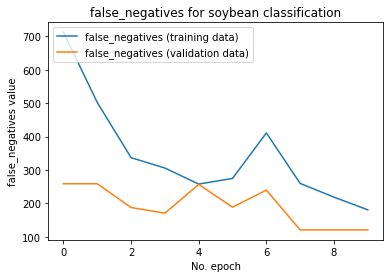

In [26]:
EPOCHS = 10
TRAIN_TEST_SPLIT = 0.25
BATCH_SIZE = 32
acc, prec, rec, auc = train_models(images, labels)

In [28]:
print("Acurácia média: ",np.mean(acc), np.std(acc))
print("Precisão média: ",np.mean(prec), np.std(prec))
print("Recall médio: ",np.mean(rec), np.std(rec))
print("Auc média: ",np.mean(auc), np.std(auc))

Acurácia média:  0.7588024 0.107480854
Precisão média:  0.79327625 0.09141444
Recall médio:  0.7229748 0.14460693
Auc média:  0.8899711 0.08562636


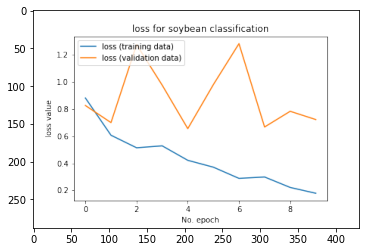

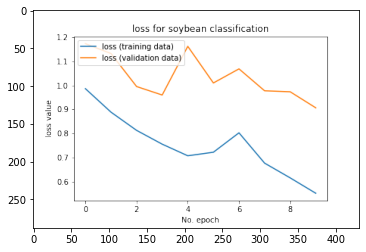

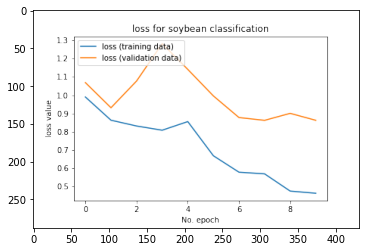

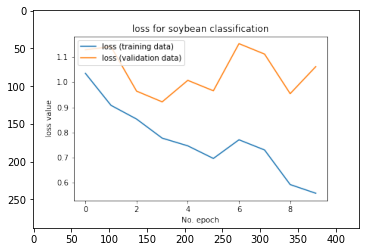

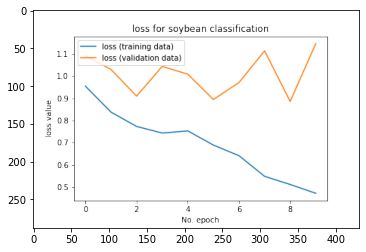

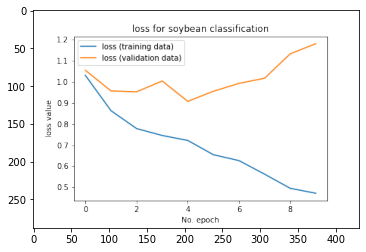

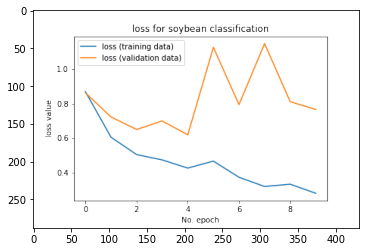

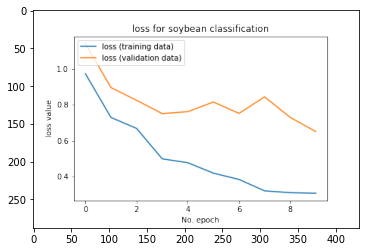

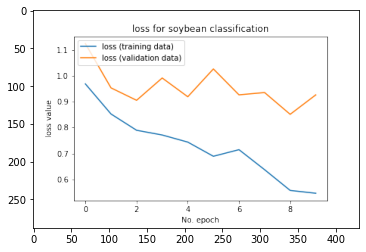

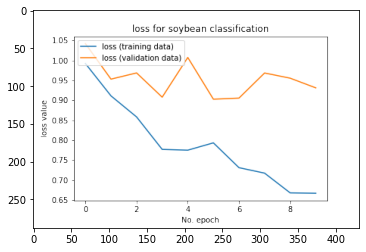

In [29]:
for model in os.listdir("../metricas/classificacao/7_d/tests-binary/adhoc/models"):
    metric_path = os.path.join("../metricas/classificacao/7_d/tests-binary/adhoc/models", model, "loss.png")
    img = plt.imread(metric_path)
    plt.imshow(img)
    plt.show()